# Chroma key

Vamos a implementar el efecto de composición de imágenes [chroma key](https://en.wikipedia.org/wiki/Chroma_key).

In [1]:
import numpy             as np
import cv2               as cv
import skimage           as si
import matplotlib.pyplot as plt
import ipywidgets
from matplotlib.pyplot import imshow, subplot, title

%matplotlib inline

In [2]:
def fig(w,h):
    return plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2yuv(x):
    return cv.cvtColor(x,cv.COLOR_RGB2YUV)

## Chroma

Necesitamos una imagen de fondo ("*background*"). Si tuviéramos un fondo uniforme de color muy distinto al objeto (el típico fondo verde) sería más fácil separarlo. Pero vamos a trabajar con cualquier escena. Por ejemplo:

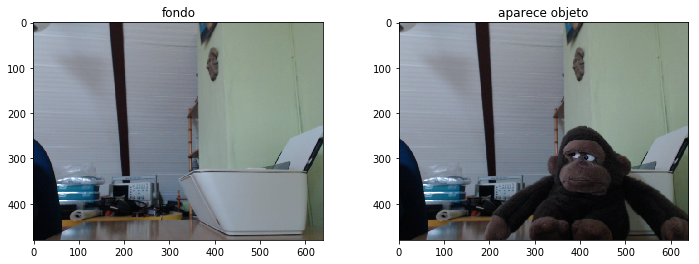

In [3]:
back = readrgb("mono-0.png")
obj  = readrgb("mono-1.png")

fig(12,4)
subplot(1,2,1); imshow(back); title('fondo')
subplot(1,2,2); imshow(obj); title('aparece objeto');

Queremos meter al personaje en un paisaje distinto.

Para ello vamos a intentar obtener una "máscara" de los pixels ocupados por el objeto. Calculamos la diferencia absoluta pixel a pixel y la binarizamos con un umbral que ajustamos por prueba y error.

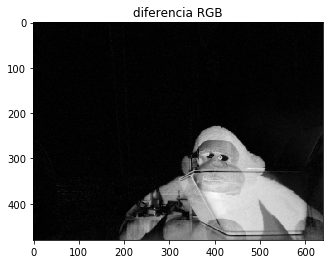

In [4]:
# diferencia de imágenes en el espacio RGB
drgb = np.sum(cv.absdiff(back,obj), axis=2)

imshow(drgb,'gray'); title('diferencia RGB');

Observamos la distribución de valores:

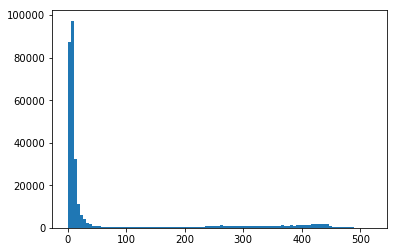

In [5]:
plt.hist(drgb.flatten(),100);

El punto de corte para separar las zonas donde realmente está el objeto se elige a ojo mirando el histograma, en un valor que esté en el valle entre los valores de diferencia bajos y altos. (Más adelante estudiaremos el umbralizado automático.)

El aspecto que tendrá la "máscara" de selección del objeto (imagen booleana que indica los píxels que pertencen al objeto) se puede mostrar de forma interactiva para cualquier umbral de corte usando la función "interactive":

In [6]:
def fun(h):
    imshow(drgb>h,'gray')

ipywidgets.interactive(fun, h=(0,350))    

interactive(children=(IntSlider(value=175, description='h', max=350), Output()), _dom_classes=('widget-interac…

Finalmente creamos la máscara con el umbral deseado y copiamos solo esos pixels a la imagen de destino (que debe ser del mismo tamaño).

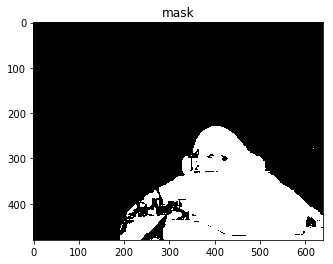

In [7]:
mask = drgb > 80

fig(12,4)
imshow(mask,'gray'); title('mask');

Finalmente elegimos una imagen de destino y copiamos los pixels del personaje con ayuda de la máscara.

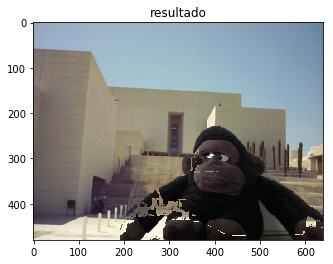

In [8]:
# el paisaje ficticio donde queremos insertar el personaje
dst  = readrgb("pano/pano003.jpg")
# nos aseguramos de que tenga el mismo tamaño que las imágenes anteriores
r,c = mask.shape
result = cv.resize(dst,(c,r))

# hay que convertir la mask a 3 canales para poder copiar rgb
mask3 = np.expand_dims(mask,axis=2)

np.copyto(result, obj, where = mask3)

imshow(result); title('resultado');
#cv.imwrite('chroma.png',cv.cvtColor(result,cv.COLOR_RGB2BGR))

La máscara no es perfecta: quedan algunos "agujeros" en las zonas donde el objeto es de un color parecido al del fondo. En este ejemplo las imágenes back y obj se han tomado fijando en modo manual la exposición y el balance de blancos de la webcam (con guvcview) para reducir en lo posible los cambios de iluminación y tono de color que se producen en modo automático cuando aparece el personaje. Si no hacemos esto los resultados serán mucho peores.

### Espacio UV

Se puede experimentar con otros espacios de color para intentar reducir algunos artefactos, como por ejemplo las sombras.

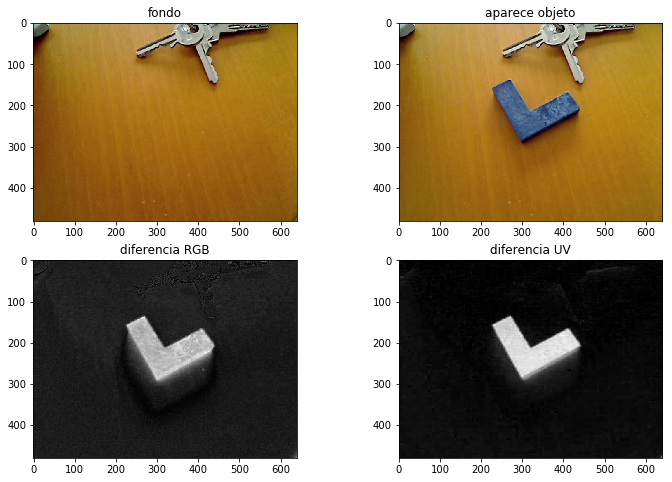

In [9]:
back = readrgb("ss0.png")
obj  = readrgb("ss1.png")

# diferencia de imágenes en el espacio RGB
drgb = np.sum(cv.absdiff(back,obj), axis=2)

# diferencia de imágenes en el espacio UV
backyuv = rgb2yuv(back)
objyuv  = rgb2yuv(obj)
duv = np.sum(cv.absdiff(backyuv,objyuv)[:,:,[1,2]], axis=2)

fig(12,8)
plt.set_cmap('gray')
subplot(2,2,1); imshow(back); title('fondo')
subplot(2,2,2); imshow(obj); title('aparece objeto')
subplot(2,2,3); imshow(drgb); title('diferencia RGB')
subplot(2,2,4); imshow(duv); title('diferencia UV');

La separación es muy buena en con los dos espacios de color, pero en este ejemplo parece que la sombra añadida por el objeto influye menos en la diferencia UV.

## Background subtraction
 
Existen [métodos automáticos](https://en.wikipedia.org/wiki/Background_subtraction) para modelar dinámicamente el fondo de la imagen y eliminarlo. El ejemplo de código `backsub.py` muestra el resultado del método [MOG2](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html) disponible en opencv, basado en un modelo de mezcla para el color de los pixels.

El problema es que si el sujeto se mantiene un rato quieto termina convirtiéndose en fondo. Para evitarlo, puede interrumpirse la actualización del modelo de fondo cuando se considere.